<a href="https://colab.research.google.com/github/leeeenammmmm/lab/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Code_Injection_Dataset

/content/drive/MyDrive/Code_Injection_Dataset


In [4]:
df_train = pd.read_csv('dataset_capec.csv')
df_train.head()

,text,label
0,GET /blog/index.php/2020/04/04/voluptatum-repr...,000 - Normal
1,GET /blog/xmlrpc.php?rsd,000 - Normal
2,GET /blog/index.php/2020/04/04/nihil-tenetur-e...,000 - Normal
3,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal
4,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal


66 - SQL Injection                        248093
000 - Normal                              226509
194 - Fake the Source of Data              55982
34 - HTTP Response Splitting               19134
126 - Path Traversal                       17595
242 - Code Injection                       13792
272 - Protocol Manipulation                 6924
310 - Scanning for Vulnerable Software      2382
153 - Input Data Manipulation               1387
Name: label, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '66 - SQL Injection'),
  Text(1, 0, '000 - Normal'),
  Text(2, 0, '194 - Fake the Source of Data'),
  Text(3, 0, '34 - HTTP Response Splitting'),
  Text(4, 0, '126 - Path Traversal'),
  Text(5, 0, '242 - Code Injection'),
  Text(6, 0, '272 - Protocol Manipulation'),
  Text(7, 0, '310 - Scanning for Vulnerable Software'),
  Text(8, 0, '153 - Input Data Manipulation')])

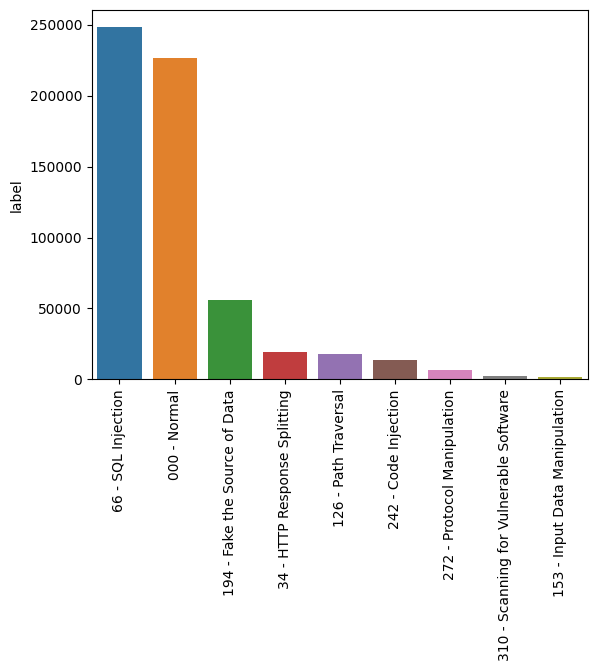

In [5]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_train['label'].value_counts()
print(x)
sns.barplot(x = x.index, y = x)
plt.xticks(rotation=90)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import json


class Vectorizer:
    def __init__(self, method='BOW', ngram_range=(1, 1), max_features=300, emb_fname='', word_index_fname=''):
        self.method = method
        if self.method == 'BOW':
            self.vectorizer = CountVectorizer(analyzer='word', input='content', ngram_range=ngram_range, max_features=max_features)
        elif self.method == 'TFIDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', input='content', max_features=max_features)
        elif self.method == 'Word2Vec':
            self.max_features = max_features
            self.emb_fname = emb_fname
            self.word_index_fname = word_index_fname
        else:
            raise ValueError('Feature extraction method does not exist.')

    def feature_extraction(self, X_train, X_test):
        train_data = self.vectorizer.fit_transform(X_train).toarray()
        test_data = self.vectorizer.transform(X_test).toarray()
        return train_data, test_data

    def get_word_index(self):
        word2id = json.load(open(self.word_index_fname, 'r'))
        return word2id

    def get_embedding_matrix(self):
        np.random.seed(0)
        word2id = self.get_word_index()
        embedding_matrix = np.random.uniform(-0.25, 0.25, [len(word2id) + 1, self.max_features])
        with open(self.emb_fname, 'r', encoding='utf-8') as f:
            for line in f:
                content = line.split(' ')
                if content[0] in word2id:
                    embedding_matrix[word2id[content[0]]] = np.array(list(map(float, content[1:])))
        return embedding_matrix

In [7]:
# Optional (not effect very much)
df_train['text'] = df_train['text'].str.replace('/',' ')
df_train.head()


,text,label
0,GET blog index.php 2020 04 04 voluptatum-repr...,000 - Normal
1,GET blog xmlrpc.php?rsd,000 - Normal
2,GET blog index.php 2020 04 04 nihil-tenetur-e...,000 - Normal
3,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal
4,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal


In [8]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_val, y_train, y_val = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))

0.8677086853666779


In [9]:
y_predict = mnb.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.81      0.93      0.87     45405
                  126 - Path Traversal       1.00      0.78      0.88      3436
         153 - Input Data Manipulation       0.11      1.00      0.19       287
         194 - Fake the Source of Data       0.98      0.91      0.94     11141
                  242 - Code Injection       0.98      0.90      0.94      2713
           272 - Protocol Manipulation       0.00      0.00      0.00      1419
310 - Scanning for Vulnerable Software       0.98      0.29      0.44       473
          34 - HTTP Response Splitting       0.95      0.92      0.94      3816
                    66 - SQL Injection       0.94      0.83      0.88     49670

                              accuracy                           0.87    118360
                             macro avg       0.75      0.73      0.68    118360
                          weighted avg

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.9595471443055086


In [11]:
y_predict = rf.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45405
                  126 - Path Traversal       1.00      0.92      0.96      3436
         153 - Input Data Manipulation       0.70      0.02      0.05       287
         194 - Fake the Source of Data       1.00      0.93      0.96     11141
                  242 - Code Injection       1.00      0.99      1.00      2713
           272 - Protocol Manipulation       0.70      0.14      0.24      1419
310 - Scanning for Vulnerable Software       0.87      0.98      0.92       473
          34 - HTTP Response Splitting       1.00      1.00      1.00      3816
                    66 - SQL Injection       0.98      0.96      0.97     49670

                              accuracy                           0.96    118360
                             macro avg       0.91      0.77      0.78    118360
                          weighted avg

In [12]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini')
dt.fit(train_features, y_train)
print(dt.score(test_features, y_val))

0.9595640419060494


In [13]:

y_predict = dt.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45405
                  126 - Path Traversal       1.00      0.92      0.96      3436
         153 - Input Data Manipulation       0.67      0.02      0.04       287
         194 - Fake the Source of Data       1.00      0.93      0.96     11141
                  242 - Code Injection       1.00      0.99      0.99      2713
           272 - Protocol Manipulation       0.68      0.15      0.24      1419
310 - Scanning for Vulnerable Software       0.87      0.98      0.92       473
          34 - HTTP Response Splitting       1.00      1.00      1.00      3816
                    66 - SQL Injection       0.98      0.96      0.97     49670

                              accuracy                           0.96    118360
                             macro avg       0.90      0.77      0.78    118360
                          weighted avg

In [14]:

from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=10)
abc.fit(train_features, y_train)
print(abc.score(test_features, y_val))

0.561752281176073


In [15]:
y_predict = abc.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.00      0.00      0.00     45405
                  126 - Path Traversal       0.00      0.00      0.00      3436
         153 - Input Data Manipulation       0.00      0.00      0.00       287
         194 - Fake the Source of Data       0.99      0.93      0.96     11141
                  242 - Code Injection       1.00      0.97      0.98      2713
           272 - Protocol Manipulation       0.00      0.00      0.00      1419
310 - Scanning for Vulnerable Software       0.00      0.00      0.00       473
          34 - HTTP Response Splitting       1.00      1.00      1.00      3816
                    66 - SQL Injection       0.49      1.00      0.66     49670

                              accuracy                           0.56    118360
                             macro avg       0.39      0.43      0.40    118360
                          weighted avg

In [16]:

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, y_train)
print(lr.score(test_features, y_val))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9500591416018925


In [17]:
y_predict = lr.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.91      0.98      0.94     45405
                  126 - Path Traversal       0.98      0.91      0.94      3436
         153 - Input Data Manipulation       0.62      0.02      0.03       287
         194 - Fake the Source of Data       0.99      0.93      0.96     11141
                  242 - Code Injection       1.00      0.97      0.99      2713
           272 - Protocol Manipulation       0.00      0.00      0.00      1419
310 - Scanning for Vulnerable Software       0.85      0.94      0.89       473
          34 - HTTP Response Splitting       1.00      1.00      1.00      3816
                    66 - SQL Injection       0.98      0.95      0.96     49670

                              accuracy                           0.95    118360
                             macro avg       0.81      0.75      0.75    118360
                          weighted avg